In this problem we will train a neural network from scratch using numpy. In practice, you will never need to do this (you'd just use TensorFlow or PyTorch). But hopefully this will give us a sense of what's happening under the hood. 

For training/testing, we will use the standard MNIST benchmark consisting of images of handwritten images. 



In the second demo, we worked with autodiff. Autodiff enables us to implicitly store how to calculate the gradient when we call backward. We implemented some basic operations (addition, multiplication, power, and ReLU). In this homework problem, you will implement backprop for more complicated operations directly. Instead of using autodiff, you will manually compute the gradient of the loss function for each parameter.

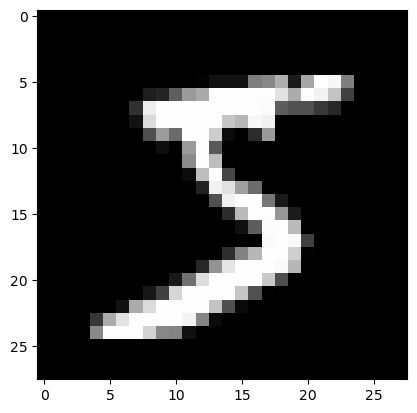

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0],cmap='gray');

Loading MNIST is the only place where we will use TensorFlow; the rest of the code will be pure numpy.

Let us now set up a few helper functions. We will use sigmoid activations for neurons, the softmax activation for the last layer, and the cross entropy loss.

In [35]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  
  x = np.clip(x, -500, 500) # We get an overflow warning without this
  
  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(10)
  result[x] = 1
  return result

OK, we are now ready to build and train our model. The input is an image of size 28x28, and the output is one of 10 classes. So, first: 

Q1. Initialize a 2-hidden layer neural network with 32 neurons in each hidden layer, i.e., your layer sizes should be: 

784 -> 32 -> 32 -> 10

If the layer is $n_{in} \times n_{out}$ your layer weights should be initialized by sampling from a normal distribution with mean zero and variance 1/$\max(n_{in},n_{out})$.

In the Below Code we initalize weights and biases for the Neural Netowork:
-We first define the layer size for each layer
-The weights are intialized such that the initalization is from a normal distribution with zero mean and variance of $1/ max(n_{in}, n_{out})$
- The size of each weight matrix is (size of input layer, size of output layer) for example: weight matrix which connects input to 1st hidden layer: (32, 784)
- The size of each bias matrix is (size of the output layer, 1) for example: bias matrix which connects input to 1st hidden layer: (32, 1)

In [36]:
import math

# Initialize weights of each layer with a normal distribution of mean 0 and
# standard deviation 1/sqrt(n), where n is the number of inputs.
# This means the weighted input will be a random variable itself with mean
# 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(80085)
# Define the sizes of the layers in the neural network
layer_sizes = [784, 32, 32, 10]

# Initialize weights and biases for each layer
weights = [] # List to store weight matrices for each layer
biases = []    # List to store bias vectors for each layer

# Loop through each layer (except the output layer)
for i in range(len(layer_sizes) - 1):
    # Initialize weights
    weight_shape = (layer_sizes[i+1], layer_sizes[i])  # Define the shape of the weight matrix
    weight_variance = 1.0 / np.sqrt(max(weight_shape))  # He initialization for weights
    weight_values = np.random.normal(loc=0.0, scale=weight_variance, size=weight_shape)
    weights.append(weight_values)  # Add the weight matrix to the list of weights

    # Initialize biases
    bias_shape = (layer_sizes[i+1], 1) # Define the shape of the bias vector
    bias_values = np.zeros(bias_shape)  # Initialize biases to zero
    biases.append(bias_values)  # Add the bias vector to the list of biases

# Display the initialized weights and biases
for i, (w, b) in enumerate(zip(weights, biases), 1):
    print(f"Layer {i}:")
    print(f"Weights shape: {w.shape}") # Display the shape of the weight matrix
    print(f"Biases shape: {b.shape}")  # Display the shape of the bias vector
    print()

for i in range(len(weights)):
    print(f"Layer: {i + 1}")
    print(weights[i].shape)

Layer 1:
Weights shape: (32, 784)
Biases shape: (32, 1)

Layer 2:
Weights shape: (32, 32)
Biases shape: (32, 1)

Layer 3:
Weights shape: (10, 32)
Biases shape: (10, 1)

Layer: 1
(32, 784)
Layer: 2
(32, 32)
Layer: 3
(10, 32)


Next, we will set up the forward pass. We will implement this by looping over the layers and successively computing the activations of each layer. 

Q2. Implement the forward pass for a single sample, and for the entire dataset.


Right now, your network weights should be random, so doing a forward pass with the data should not give you any meaningful information. Therefore, in the last line, when you calculate test accuracy, it should be somewhere around 1/10 (i.e., a random guess).

Below function of one_hot_softmax is a function which takes the ouptput given by the neural network as the input and outputs an array of 0s and 1 which has the max probability in the original input to the function.
example:
input: [0.2, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
output: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
def one_hot_softmax(softmax_output):
    
    # Create one-hot encoding
    max_indices = np.argmax(softmax_output)
    one_hot_output = np.zeros_like(softmax_output)
    one_hot_output[max_indices] = 1
    
    return one_hot_output

The feed_forward_sample:
This function takes a sample image and its actual label. It flattens the image into a array and inputs it into the neural netowork.
The for loop iterates over all the layers of the network and compute values on each layer using previously defined weights and bias and use sigmoid activation function for all layers accept last layer.
The last layer has the activation function of softmax.
Finaly we calcualte the loss as cross entropy loss and we return the prediction for the given array




Feed Forward Dataset function:
a for loop is run over all example and each example is send to the feed forward sample function with its actual label 

In [38]:
def feed_forward_sample(sample, y):
  """ Forward pass through the neural network.
    Inputs:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: the cross entropy loss, most likely class
  """
     # Reshape the input sample into a column vector
  sample = np.array(sample.flatten()).reshape(784, 1)
  a = {1: sample} # Initialize the activation dictionary with the input sample
  z = {}  # Initialize the dictionary to store the weighted inputs
     # Forward pass through the network
  for l in range(1, len(weights)):
      node_in = a[l]
      # Compute the weighted inputs for each layer and apply the activation function
      z[l + 1] =  weights[l - 1].dot(node_in) + biases[l - 1]
      a[l + 1] = sigmoid(z[l + 1])
 # Output layer calculations
  z[4] = weights[2].dot(a[3]) + biases[2]
  a[4] = softmax(z[4])
# Convert the true label 'y' into a one-hot encoded vector
  y = integer_to_one_hot(y, 10)
    # Compute the cross-entropy loss between the predicted and true labels
  loss = cross_entropy_loss(y, a[4].flatten()) 
    # Extract the output of the softmax layer (most likely class probabilities)
  one_hot_guess = a[4].flatten()
    # Convert the softmax output into a one-hot representation
  one_hot_output = one_hot_softmax(one_hot_guess)
  return loss, one_hot_output


def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  for i in range(len(x)):
      losses[i] , one_hot_guesses[i]= feed_forward_sample(x[i] , y[i])

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1
    
  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")  

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...

Average loss: 2.36
Accuracy (# of correct guesses): 808.0 / 10000 ( 8.08 %)



OK, now we will implement the backward pass using backpropagation. We will keep it simple and just do training sample-by-sample (no minibatching, no randomness).

Q3: Compute the gradient of all the weights and biases by backpropagating derivatives all the way from the output to the first layer. 





init_tri_values function:
This function is used to initlaize the change is weights and biases. THe initialization is array of zeros and same size as previously initalized weights and biases.

calculate_out_layer_delta function: This function caluclate the delta for the output layer. Delta can aslo be said as the diffenriation of y with respect to z.

calculate_hidden_delta: This function calculate the delta for hidden layer. This delta depends on the delta from the next layer, weight and z value of the current layer.

In [39]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(0, len(nn_structure) - 1):
        tri_W[l] = np.zeros((nn_structure[l+1], nn_structure[l]))
        tri_b[l] = np.zeros((nn_structure[l+1], 1))
    return tri_W, tri_b

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * dsigmoid(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return w_l.T.dot(delta_plus_1) * dsigmoid(z_l)

Below code is a algorithm of backpropogation using gradient descent. we first calcualte the forward pass prediction and based on the prediction and actual label, we calcualte output layer delta and loop it backwards to get all the change in weights and biases and deltas for each layer. After the loop we update the weights and biases.

In [40]:
def train_one_sample(sample, y, learning_rate=0.003):
    # Flatten the input sample and reshape it into a column vector
  sample = np.array(sample.flatten()).reshape(784, 1)
  a = {1: sample} # Initialize the activation dictionary with the input sample
  z = {} # Initialize the dictionary to store the weighted inputs
  delta = {}
  for l in range(1, len(weights)):
      node_in = a[l]
       # Calculate the weighted inputs for each layer and apply the activation function
      z[l + 1] =  weights[l - 1].dot(node_in) + biases[l - 1]
      a[l + 1] = sigmoid(z[l + 1])
    # Output layer calculations  
  z[4] = weights[2].dot(a[3]) + biases[2]
  a[4] = softmax(z[4])
  # Convert the true label 'y' into a one-hot encoded vector
  y = (integer_to_one_hot(y, 10)).reshape(10,1)
  loss = cross_entropy_loss(y, a[4])    # Compute the cross-entropy loss between the predicted and true labels
  yHat = a[4]

  
  # Backward pass
  tri_W, tri_b = init_tri_values(layer_sizes) # Initialize the gradients for weights and biases
  for l in range(len(layer_sizes), 0, -1): # Iterate through the layers in reverse order
      if l == len(layer_sizes):
           # Calculate the error at the output layer
          delta[l] = calculate_out_layer_delta(y, a[l], z[l])
      else:
          if l > 1:
               # Calculate the error for hidden layers
              delta[l] = calculate_hidden_delta(delta[l + 1], weights[l - 1], z[l])
               # Accumulate gradients for weights and biases
          tri_W[l - 1] += delta[l+1].dot(a[l].T)
          tri_b[l - 1] += delta[l + 1]
 # Update weights and biases using gradient descent
  for l in range(len(weights), 1 , -1):
      weights[l - 1] += -learning_rate * (tri_W[l - 1])
      biases[l - 1] += -learning_rate * (tri_b[l - 1])

  return weights, biases
    


Finally, train for 3 epochs by looping over the entire training dataset 3 times.

Q4. Train your model for 3 epochs.

Below code calls the above train example code to train over all training example and get a near optimal weights and biases values which are then test on the test dataset and this porcess continues for 3 epochs. 

In [ ]:
def train_one_epoch(learning_rate=0.003):
  print("*************************************************\n")
  print("Training for one epoch over the training dataset...")
   # Loop over the entire training dataset and train each sample
  # Q4. Write the training loop over the epoch here.
  # ...
  for j in range(len(x_train)):
     train_one_sample(x_train[j], y_train[j])
          
  print("Finished training.\n")
# Function to perform forward pass on the test dataset
feed_forward_test_data()
# Function to perform testing and training
def test_and_train():
    # Train the model for one epoch
  train_one_epoch()
    # Perform forward pass on the test data
  feed_forward_test_data()
# Perform testing and training for a certain number of epochs
for i in range(3): 
  test_and_train()

Feeding forward all test data...

Average loss: 2.36
Accuracy (# of correct guesses): 808.0 / 10000 ( 8.08 %)

*************************************************

Training for one epoch over the training dataset...


As Seen above the loss decreases after each epoch and the correct predciton increases after each epoch whihch signifies that our neural network is working properly


That's it! 

Your code is probably very time- and memory-inefficient; that's ok. There is a ton of optimization under the hood in professional deep learning frameworks which we won't get into.

If everything is working well, you should be able to raise the accuracy from ~10% to ~70% accuracy after 3 epochs.


**Attributes & Values for Satyrium spini (Spine Hairstreak):**

- **Name**: Satyrium spini (Spine Hairstreak) 
- **Wingspan**: 1.5 to 2 inches (3.8 to 5.1 cm) 
- **Color**: Dark brown or black with blue and orange markings 
- **Underside of Wings**: Mottled brown with orange and white markings 
- **Distinctive Features**: Spine-like projection at the end of the hind wing 
- **Habitat**: Forests, fields, and gardens 
- **Nectar Sources**: Variety of flowers 
- **Attracted to**: Bright, open areas